# Lecture 38: Multiple Regression

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
%matplotlib inline
np.set_printoptions(legacy='1.13')
import time

**All the usual regression functions.**

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def rmse(t, x, y):
    """The RMSE of predicting y based on x."""
    r = correlation(t, x, y)
    return np.std(t.column(y)) * np.sqrt(1 - r**2)

## House sales

In [3]:
# House sales in Ames, Iowa, 2006-2010
all_sales = Table.read_table('house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


**Q:** Suppose you wanted to predict the sale price of a house.  What do you think would be the best attribute to use?

A. The size of the house  
B. The age of the house  
C. The location of the house  
D. The year of the sale  
E. Something else  

<br/><br/><br/><br/><br/><br/><br/>

r:     0.642466254103
RMSE:  56188.3451165


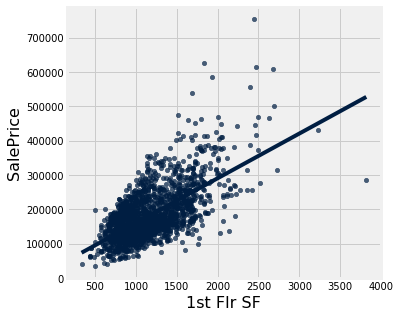

In [4]:
def plot_and_correlate(table, x, y):
    table.scatter(x, y, fit_line=True)
    print('r:    ', correlation(table, x, y))
    print('RMSE: ', rmse(table, x, y))

plot_and_correlate(sales, '1st Flr SF', 'SalePrice')

r:     0.35752189428
RMSE:  68476.5831262


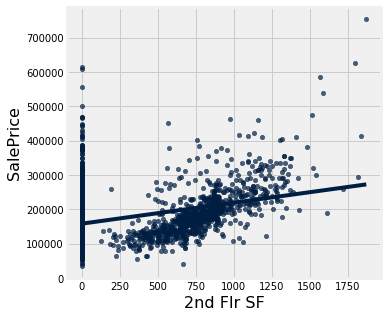

In [5]:
plot_and_correlate(sales, '2nd Flr SF', 'SalePrice')

r:     0.714200406454
RMSE:  51699.9069403


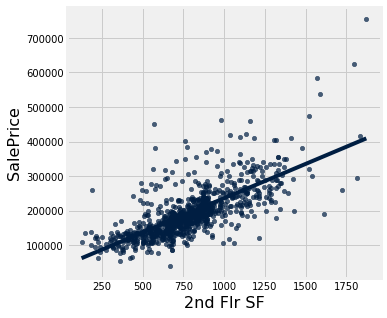

In [6]:
has_2nd_flr = sales.where('2nd Flr SF', are.above(0))
plot_and_correlate(has_2nd_flr, '2nd Flr SF', 'SalePrice')

r:     0.782192055613
RMSE:  45682.8935093


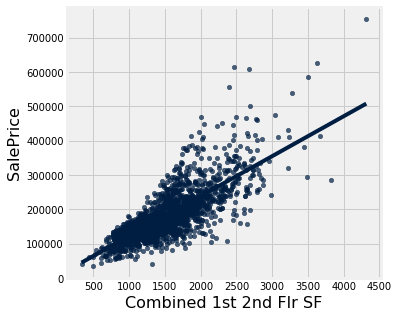

In [7]:
combined_floor_sf = sales.with_column(
    'Combined 1st 2nd Flr SF', 
    sales.column('1st Flr SF') + sales.column('2nd Flr SF')
)
plot_and_correlate(combined_floor_sf, 
                   'Combined 1st 2nd Flr SF', 'SalePrice')

r:     0.885196595882
RMSE:  34111.0588296


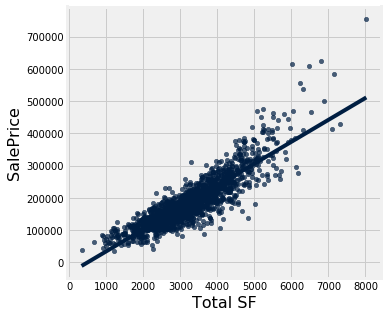

In [8]:
total_sf = sales.with_column(
    'Total SF', 
    sales.column('1st Flr SF') + sales.column('2nd Flr SF')
    + sales.column('Total Bsmt SF') + sales.column('Garage Area')
    + sales.column('Wood Deck SF') + sales.column('Open Porch SF')
)
plot_and_correlate(total_sf, 
                   'Total SF', 'SalePrice')

Harder to incorporate into sum:  lot area.  Maybe we should weight it differently than SF?  What about year built and year sold?

## Weighted sum of attributes

Given $n$ attributes 
$$x_1, x_2, \ldots, x_n$$
predict $y$ by weighting each attribute with its own coefficient:
$$y = a_1 \cdot x_1 + a_2 \cdot x_2 + \ldots + a_n \cdot x_n + b \cdot 1$$

In [9]:
first_house = np.array(sales.drop('SalePrice').row(0))
first_house

array([  1656.,      0.,   1080.,    528.,    210.,     62.,  31770.,
         1960.,   2010.])

In [10]:
len(first_house)

9

**Q:** How many coefficients (a's and b's) do we need to predict $y$ for this set of attributes?

A. 8  
B. 9  
C. 10  
D. 11  
E. None of the above

<br/><br/><br/><br/><br/>

In [11]:
some_dumb_weights = make_array(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
some_dumb_weights

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
#some_dumb_weights * first_house

In [13]:
np.sum(some_dumb_weights * np.append(first_house, make_array(1)))

225323.0

In [14]:
def predict(weights, attributes):
    """Use multiple linear regression to predict a value.
    The weights array contains the coefficients to use for
    prediction:  a1, a2, ..., an, b.
    The attributes array contains the attributes to use
    for prediction:  x1, x2, ..., xn.
    """
    attributes_with_extra_1 = np.append(attributes, make_array(1))
    return np.sum(weights * attributes_with_extra_1)

predict(some_dumb_weights, first_house)

225323.0

In [15]:
sales.column('SalePrice').item(0)

215000

In [16]:
def sales_rmse(weights):
    """The RMSE that results from using the weights array
    to predict the sale prices for the houses in the sales table.
    """
    def predict_row(row):
        return predict(weights, np.array(row))
    predicted_prices = sales.drop('SalePrice').apply(predict_row)
    actual_prices = sales.column('SalePrice')
    errors = actual_prices - predicted_prices
    return np.sqrt(np.mean(errors**2))

sales_rmse(some_dumb_weights)

108589.97752838834

**Q:** What technique could we use to find the best weights?

A. Resampling  
B. Hypothesis testing  
C. Minimization  

<br/><br/><br/><br/><br/>

## Minimizing a function

$$f(x) = x^2 + 10$$

In [17]:
def f(x):
    """f(x) = x**2 + 10"""
    return x**2 + 10

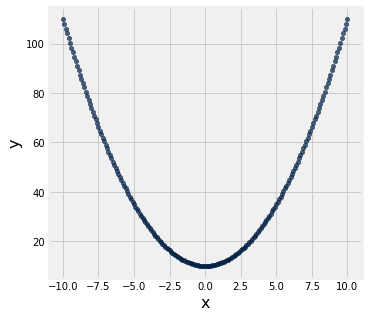

In [18]:
f_table = Table(['x', 'y'])

for x in np.arange(-10, 10.1, .1):
    y = f(x)
    f_table.append([x, y])

f_table.scatter('x', 'y')

In [19]:
best_x = minimize(f)
best_x

-3.163929398103686e-11

In [20]:
f(best_x)

10.0

*Note to self: start running RMSE computation below.*

$$g(x_1, x_2) = x_1^2 + x_2^2 + 10$$

In [21]:
def g(xs):
    """g([x1,x2]) = x1**2 + x2**2 + 10"""
    return xs.item(0) ** 2 + xs.item(1) ** 2 + 10

In [22]:
g_table = Table(['x1', 'x2', 'y'])

for x1 in np.arange(-10, 10.1, 1):
    for x2 in np.arange(-10, 10.1, 1):
        y = g(make_array(x1, x2))
        g_table.append([x1, x2, y])

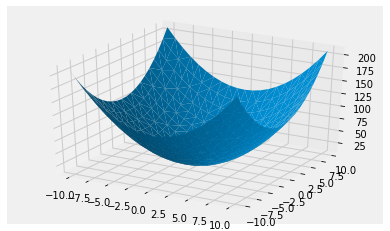

In [23]:
fig = plots.figure()
ax = plots.axes(projection='3d')
ax.plot_trisurf(g_table.column('x1'), 
           g_table.column('x2'), 
           g_table.column('y'));

In [24]:
best_xs = minimize(g, array=True, start=make_array(1,1))
best_xs

array([ -3.16390719e-11,  -3.16390719e-11])

In [25]:
g(best_xs)

10.0

**Minimizing RMSE.**

In [26]:
# long computation (2 minutes)
print(time.ctime())
best_weights = minimize(sales_rmse, start=np.ones(10), array=True)
print(time.ctime())
best_weights

Wed May 16 12:09:32 2018
Wed May 16 12:10:52 2018


array([  7.24660364e+01,   7.63863656e+01,   5.98158336e+01,
         7.77651082e+01,   4.83408775e+01,   3.63592752e+01,
         4.66444836e-01,  -5.09712146e+01,  -8.22513401e+00,
         7.71174769e+04])

In [27]:
weight_labels = list(sales.labels[1:]) + ['b']
weights = Table().with_columns(
    'Attribute', weight_labels,
    'Weight', list(best_weights)
)
weights.show()

Attribute,Weight
1st Flr SF,72.466
2nd Flr SF,76.3864
Total Bsmt SF,59.8158
Garage Area,77.7651
Wood Deck SF,48.3409
Open Porch SF,36.3593
Lot Area,0.466445
Year Built,-50.9712
Yr Sold,-8.22513
b,77117.5


In [28]:
slope(sales, '1st Flr SF', 'SalePrice')

130.23462780094238

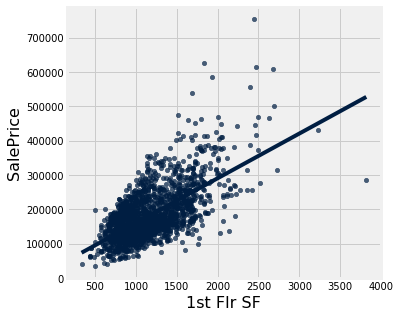

In [29]:
sales.scatter('1st Flr SF', 'SalePrice', fit_line=True)

**Caution:** tempting to conclude "buyers pay $72/SF on the first floor," but that might not be true.

In [30]:
sales_rmse(best_weights)

34024.327773674609

## Nearest neighbors

*Note to self: start running prediction computation below.*

In [31]:
def standard_units(array):
    """Convert array to standard units.
    """
    return (array - array.mean()) / array.std()
    
def standardize(t):
    """Convert table t to standard units.
    """
    su = Table()
    for label in t.labels:
        su = su.with_column(
            label + ' (su)', standard_units(t.column(label))
        )
    return su

def in_su(value, array):
    """Return value in standard units according to 
    the distribution of array.
    """
    return (value - array.mean()) / array.std()

def new_point_in_su(new_point, table):
    """Return the new point, with all its coordinates converted
    to standard units, according to the distribution given by
    the table.  The first element of the new_point array 
    corresponds to the first column of the table, and so forth.
    """
    new_point_su = make_array()
    num_dimensions = len(new_point)
    for i in np.arange(num_dimensions):
        coord_su = in_su(new_point.item(i), table.column(i))
        new_point_su = np.append(new_point_su, coord_su)
    return new_point_su

def distance(a, b):
    """Returns the distance between a and b, where a and b
    are both arrays representing points.
    """
    return np.sqrt(np.sum((a - b)**2))

def all_distances(new_point, table):
    """Returns a table with two columns labeled Distance and Class.  
    The first column contains the distance from new_point to each 
    point in table.  The second column contains the label of the 
    point in table.  The classes should be in the final column of 
    table.  The table that is returned is sorted in ascending order
    by Distance.
    """

    def distance_from_new(row):
        """Return the distance between row and new_point.
        """
        return distance(np.array(row), new_point)

    last_column_index = table.num_columns - 1
    table_without_classes = table.drop(last_column_index)
    classes = table.column(last_column_index)
    
    distances = Table().with_columns(
        'Distance', table_without_classes.apply(distance_from_new),
        'Class', classes
    ).sort('Distance')

    return distances

def train_knn_su_predictor(train, k):
    """Create a k-nearest-neighbor predictor.  The last column 
    of the training table should be the response variable, 
    and the preceeding columns should be the attributes.  
    The names of the columns do not matter.  The predictor
    will work in standard units; but, the training table should 
    be in original units.    
    
    Returns a function.  That function takes as input a 
    new point in original units. The function returns the 
    prediction as output."""

    last_column_index = train.num_columns-1
    train_su = standardize(train.drop(last_column_index)).with_column(
        train.labels[last_column_index], train.column(last_column_index)
    )
    
    def predict_new_point(new_point):
        """Return the prediction for new_point, which
        should still be in original units.
        """
        new_point_su = new_point_in_su(new_point, train)
        distances = all_distances(new_point_su, train_su)
        top_k = distances.take(np.arange(k)).column('Class')
        #####################################################
        return np.mean(top_k)  
        # THE LINE ABOVE IS THE ONLY THING THAT CHANGED
        #####################################################
    
    return predict_new_point

In [32]:
# long computation (3 min)

print(time.ctime())
training_sales = sales.drop('SalePrice').with_column(
    'SalePrice', sales.column('SalePrice')
)  # move SalePrice to be the last column

price_predictor = train_knn_su_predictor(training_sales, 5)
nn_predictions = training_sales.drop('SalePrice').apply(price_predictor)
sales_and_nn_predictions = training_sales.with_column(
    'Predicted', nn_predictions
)
print(time.ctime())

sales_and_nn_predictions

Wed May 16 12:10:52 2018
Wed May 16 12:12:34 2018


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold,SalePrice,Predicted
1656,0,1080,528,210,62,31770,1960,2010,215000,207180
896,0,882,730,140,0,11622,1961,2010,105000,127660
1329,0,1329,312,393,36,14267,1958,2010,172000,164805
2110,0,2110,522,0,0,11160,1968,2010,244000,224460
928,701,928,482,212,34,13830,1997,2010,189900,186980
926,678,926,470,360,36,9978,1998,2010,195500,190600
1028,776,994,442,140,60,7500,1999,2010,189000,186118
763,892,763,440,157,84,10000,1993,2010,175900,185998
1187,0,1168,420,483,21,7980,1992,2010,185000,166220
789,676,789,393,0,75,8402,1998,2010,180400,186780


In [33]:
nn_residuals = sales_and_nn_predictions.column('SalePrice') - sales_and_nn_predictions.column('Predicted')
nn_rmse = np.sqrt(np.mean(nn_residuals ** 2))
nn_rmse

26456.156667834184

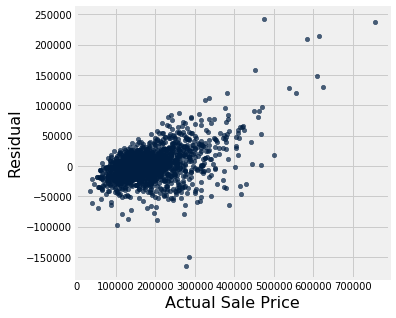

In [34]:
Table().with_columns(
    'Actual Sale Price', sales_and_nn_predictions.column('SalePrice'),
    'Residual', nn_residuals
).scatter('Actual Sale Price', 'Residual')

**Next step to compare models:** Bootstrap to estimate their accuracies on randomly split training/test tests.